## インポート宣言

In [87]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

## モデルの入力次元

In [88]:
# 28ドット×28ドット×1チャンネル
img_rows = 28
img_cols = 28
channels = 1

# 入力画像の次元
img_shape = (img_rows, img_cols, channels)

# 生成器の入力として使用されるノイズベクトルの次元（100個）
z_dim = 100

## 生成器

In [89]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # 全結合層
    model.add(Dense(128, input_dim=z_dim))

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 出力層（tanh）
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # 生成器の出力が画像サイズになるようにreshapeする（28*28*1）
    model.add(Reshape(img_shape))

    return model

## 識別器

In [90]:
def build_discriminator(img_shape):

    model = Sequential()

    # 入力画像を一列に並べる
    model.add(Flatten(input_shape=img_shape))

    # 全結合層
    model.add(Dense(128))

    # 活性化関数（Leaky ReLU）
    model.add(LeakyReLU(alpha=0.01))

    # 出力層（sigmoidで0～1を出力）
    model.add(Dense(1, activation='sigmoid'))

    return model

## GANの構築

In [91]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 生成器と識別器の統合
    model.add(generator)
    model.add(discriminator)

    return model

## コンパイル

In [92]:
# 識別器の構築とコンパイル
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 生成器の構築
generator = build_generator(img_shape, z_dim)

# 生成器の構築中は識別器のパラメータを固定（識別器は学習しない）
discriminator.trainable = False

# 生成器の訓練の為、識別器は固定し、GANモデルの構築とコンパイル
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
            optimizer=Adam())

## 画像を表示する関数定義

In [93]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # ランダムノイズのサンプリングを生成
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # ランダムノイズを使用して生成器で画像を作る（学習中）
    gen_imgs = generator.predict(z)

    # 画像の画素値を[0,1]の範囲にスケールする
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 画像をグリッドに並べる
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 画像描画
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## 学習

C:\Users\tatsu\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\tatsu\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.089927, acc.: 96.09%] [G loss: 4.810467]
2000 [D loss: 0.057816, acc.: 97.66%] [G loss: 7.112782]
3000 [D loss: 0.138536, acc.: 96.09%] [G loss: 4.912353]
4000 [D loss: 0.158367, acc.: 94.14%] [G loss: 8.424467]
5000 [D loss: 0.223576, acc.: 90.23%] [G loss: 4.592571]
6000 [D loss: 0.174894, acc.: 92.97%] [G loss: 4.072247]
7000 [D loss: 0.390719, acc.: 82.42%] [G loss: 3.990767]
8000 [D loss: 0.288527, acc.: 87.50%] [G loss: 4.170010]
9000 [D loss: 0.484748, acc.: 80.86%] [G loss: 2.593867]
10000 [D loss: 0.435867, acc.: 80.86%] [G loss: 3.398842]


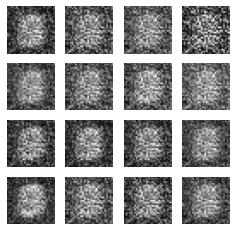

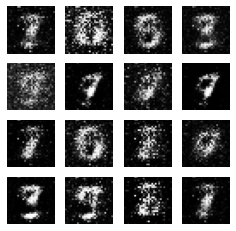

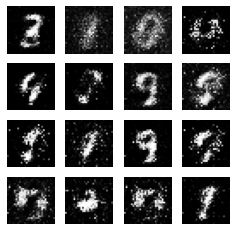

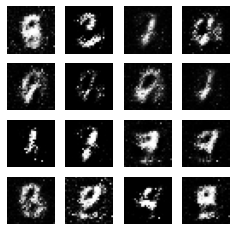

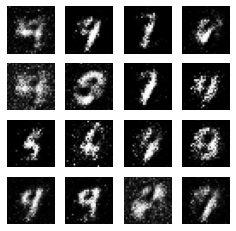

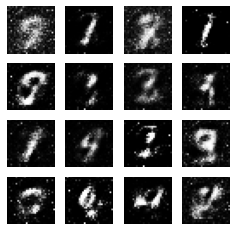

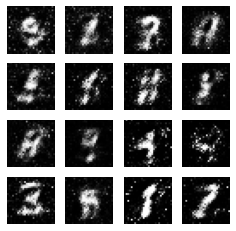

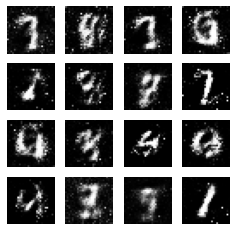

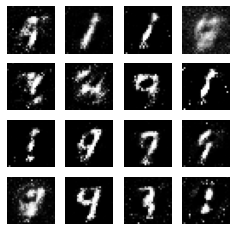

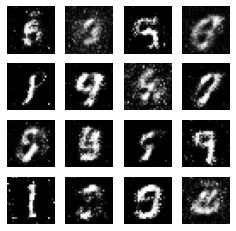

In [95]:
# 結果を保存する為の配列定義
losses = []
accuracies = []
iteration_checkpoints = []

# 10000回の学習、バッチサイズ（128）、1000回毎に結果を表示
iterations = 10000
batch_size = 128
sample_interval = 1000

# MNISTデータセットをロード
(X_train, _), (_, _) = mnist.load_data()

# [0,255]の範囲のグレースケール画素値を[-1,1]にスケーリング
X_train = X_train / 127.5 - 1.0
# (60000,28,28)→(60000,28,28,1)
X_train = np.expand_dims(X_train, axis=3)

# 本物の画像のラベルはすべて１とする
real = np.ones((batch_size, 1))

# 偽の画像のレベルはすべて０とする
fake = np.zeros((batch_size, 1))

# 10000回の学習
for iteration in range(iterations):

    # -------------------------
    #  識別器の学習
    # -------------------------

    # 本物の画像をランダムに取り出したバッチを作る
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 偽の画像を生成器で作成してバッチを作る
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 識別器の学習（独自ループで学習する場合は、fitではなくtrain_on_batchを使用する）
    # 本物で学習
    d_loss_real = discriminator.train_on_batch(imgs, real)
    # 偽物で学習
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    # ２つの成績の平均
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  生成器の学習
    # ---------------------

    # 偽の画像を生成器で作成してバッチを作る
    z = np.random.normal(0, 1, (batch_size, 100))
    # 生成器の学習（識別器のパラメータは固定）
    # 識別器が本物と認識するように学習を行う
    g_loss = gan.train_on_batch(z, real)

    # 1000回毎に結果を記録する
    if (iteration + 1) % sample_interval == 0:
        losses.append((d_loss, g_loss))
        accuracies.append(100.0 * accuracy)
        iteration_checkpoints.append(iteration + 1)
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
        sample_images(generator)

## 一つだけ画像を生成器で作ってみる

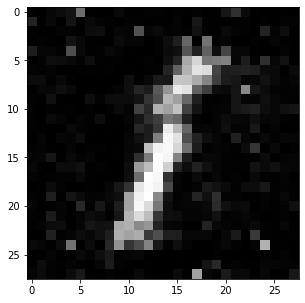

In [100]:
# ランダムノイズ
z = np.random.normal(0, 1, (1, 100))
#　学習済みの生成器で画像を作る
gen_imgs = generator.predict(z)
gen_imgs = 0.5 * gen_imgs + 0.5

# 画像描画
fig, axs = plt.subplots(1,
                        1,
                        figsize=(5, 5),
                        sharey=True,
                        sharex=True)
axs.imshow(gen_imgs[0, :, :, 0], cmap='gray')


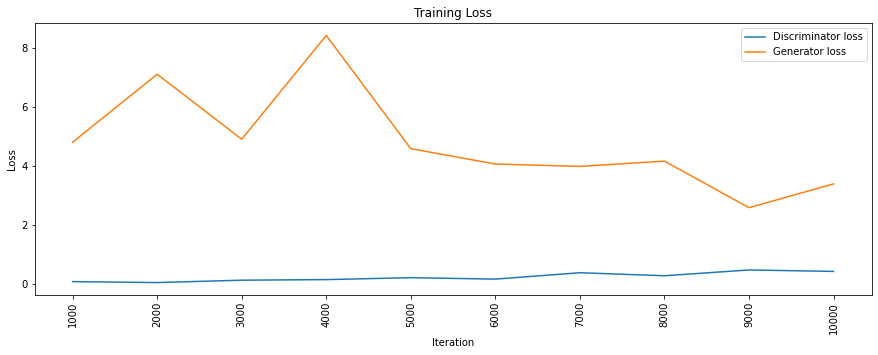

In [101]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

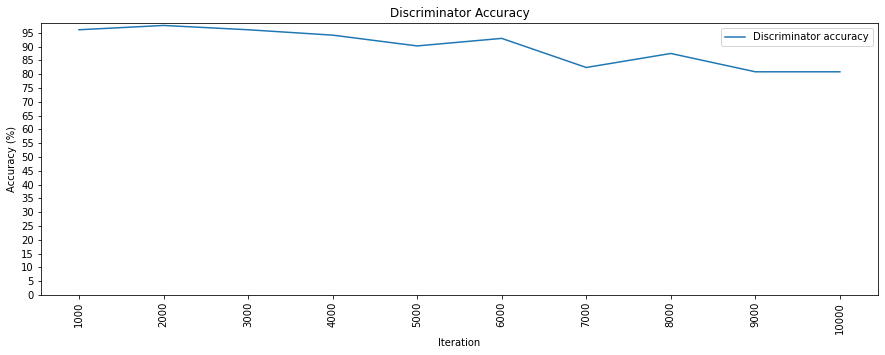

In [102]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()